# 라이브러리 불러오기

In [81]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import seaborn as sns
import folium
import datetime

# 랜덤 시드 설정

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [4]:
_train_data = pd.read_csv('../../data/data/train.csv')
_test_data = pd.read_csv('../../data/data/test.csv')
sample_submission = pd.read_csv('../../data/data/sample_submission.csv')
subway_info = pd.read_csv('../../data/data/subwayInfo.csv')
school_info = pd.read_csv('../../data/data/schoolInfo.csv')
park_info = pd.read_csv('../../data/data/parkInfo.csv')
interest_rate = pd.read_csv('../../data/data/interestRate.csv')
_train_dist_data = pd.read_csv('../../data/data/train_dist.csv')

# 데이터 전처리하기

In [91]:
# Train
# 날짜순으로 정렬
train_data = _train_dist_data.copy()
train_data["contract_year_month_day"] = pd.to_datetime(train_data["contract_year_month"] * 100 + train_data["contract_day"], format='%Y%m%d')
train_data = train_data.sort_values(by="contract_year_month_day")
# train_data.drop(columns=["contract_year_month", "contract_day"], inplace=True)

# 음수 age를 양수로 변환
train_data["age"] = train_data["age"].abs()

# duplicated data 제거
dup_df = train_data[train_data.drop(columns="index").duplicated()]
train_data = train_data.drop(index=dup_df.index)

train_data.shape

(1717611, 19)

In [92]:
# Test
test_data = _test_data.copy()

# 음수 age를 양수로 변환
test_data["age"] = test_data["age"].abs()

# 데이터 EDA 수행하기

In [8]:
print("train, test_data, sample_submission shape : ", train_data.shape, test_data.shape, sample_submission.shape)
# print("train data 상단 5개 정보 확인 : ", train_data.head())
# print("test data 상단 5개 정보 확인 : ", test_data.head())
print("sample_submission 상단 5개 정보 확인 : ", sample_submission.describe())
print("train data 변수 요약 정보 확인 : \n", train_data.describe())
print("train_dist_data 변수 요약 정보 확인 : \n", _train_dist_data.describe())
print("test data 변수 요약 정보 확인 : \n", test_data.describe())
print("subway_info 변수 요약 정보 확인 : \n", subway_info.describe())
print("school_info 변수 요약 정보 확인 : \n", school_info.describe())
print("park_info 변수 요약 정보 확인 : \n", park_info.describe())
print("interest_rate 변수 요약 정보 확인 : \n", interest_rate.describe())

train, test_data, sample_submission shape :  (1717611, 19) (150172, 10) (150172, 2)
sample_submission 상단 5개 정보 확인 :                index   deposit
count  150172.00000  150172.0
mean    75085.50000       0.0
std     43351.06665       0.0
min         0.00000       0.0
25%     37542.75000       0.0
50%     75085.50000       0.0
75%    112628.25000       0.0
max    150171.00000       0.0
train data 변수 요약 정보 확인 : 
               index       area_m2  contract_year_month  contract_day  \
count  1.717611e+06  1.717611e+06         1.717611e+06  1.717611e+06   
mean   9.019509e+05  7.524180e+01         2.021336e+05  1.590339e+01   
min    0.000000e+00  1.032150e+01         2.019040e+05  1.000000e+00   
25%    4.534015e+05  5.975010e+01         2.020080e+05  9.000000e+00   
50%    9.022850e+05  7.792000e+01         2.021110e+05  1.600000e+01   
75%    1.351972e+06  8.496000e+01         2.022120e+05  2.300000e+01   
max    1.801227e+06  3.173600e+02         2.023120e+05  3.100000e+01   
std    5.1

# 클러스터링

In [100]:
kmeans = KMeans(n_clusters=100)
train_data['cluster_100'] = kmeans.fit_predict(train_data[['latitude', 'longitude']])

In [101]:
clusters = train_data[["cluster_100", "latitude", "longitude", "deposit"]].groupby("cluster_100").mean()

In [151]:
# 지도 생성 (초기 중심 좌표와 줌 레벨 설정)
m = folium.Map(location=[37.5665, 126.9780], zoom_start=12)  # 서울 좌표 예시

# norm으로 red의 채도 변화 후 hex값으로 저장
norm = (clusters["deposit"] - clusters["deposit"].min()) / (clusters["deposit"].max() - clusters["deposit"].min())
colors = [(mcolors.to_hex([1-c, 0.5-c/2, 1])) for c in norm]

# 지도에 마커 추가 (서울 위치에 마커 추가)
for index, (lat, lon, deposit) in enumerate(zip(clusters["latitude"], clusters["longitude"], clusters["deposit"])):
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,  # 원의 크기를 조정
        popup=deposit,
        color=colors[index],
        fill=True,
        fill_color=colors[index]
    ).add_to(m)
    
m

# 대회에 필요한 데이터만 활용하기

In [116]:
train_data.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day',
       'contract_type', 'floor', 'built_year', 'latitude', 'longitude', 'age',
       'deposit', 'nearest_subway_distance', 'nearest_subway_id',
       'nearest_school_distance', 'nearest_school_id', 'nearest_park_distance',
       'nearest_park_id', 'interest_rate', 'contract_year_month_day',
       'cluster'],
      dtype='object')

In [102]:
# 필요 없는 column 제거
train_df = train_data.drop(columns=["index", "contract_year_month_day"])

# contract_year_month, contract_day를 contract_year_month_day로 통합
train_df["contract_year_month_day"] = train_df["contract_year_month"] * 100 + train_df["contract_day"]
train_df.drop(columns=["contract_year_month", "contract_day"], inplace=True)

In [103]:
# cluster를 one-hot encoding
train_df = pd.get_dummies(train_df, columns=["cluster_100"])
train_df.head()

,area_m2,contract_type,floor,built_year,latitude,longitude,age,deposit,nearest_subway_distance,nearest_subway_id,...,cluster_100_90,cluster_100_91,cluster_100_92,cluster_100_93,cluster_100_94,cluster_100_95,cluster_100_96,cluster_100_97,cluster_100_98,cluster_100_99
942790,59.9100,2,12,2016,37.547574,127.012878,3,61000.0,268.905515,158.0,...,False,False,False,False,False,False,False,False,False,False
22731,59.9940,2,23,2005,37.755550,127.075388,14,17000.0,215.599025,632.0,...,False,False,False,False,False,False,False,False,False,False
22544,84.9454,2,9,2017,37.750609,127.103420,2,25000.0,1732.496540,639.0,...,False,False,False,False,False,False,False,False,False,False
1036408,126.6211,2,2,2018,37.480071,127.002332,1,133000.0,444.243894,108.0,...,False,False,False,False,False,False,False,False,False,False
1036407,103.9700,2,1,1982,37.481214,127.001372,37,57000.0,334.044606,108.0,...,False,False,False,False,False,False,False,False,False,False


In [104]:
# nearest_subway_id를 one-hot encoding
train_df = pd.get_dummies(train_df, columns=["nearest_subway_id"])
train_df.shape

(1717611, 668)

In [105]:
# contract_type을 one-hot encoding
train_df = pd.get_dummies(train_df, columns=["contract_type"])
train_df.shape

(1717611, 670)

# LightGBM 모델 훈련 with KFold

In [112]:
n_splits = 5  # 폴드 개수 설정
kf = KFold(n_splits=n_splits, shuffle=False)

batch_num = 30  # batch 개수 설정
mae_list = []  # 폴드별 MAE를 저장할 리스트

lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)

for train_index, val_index in kf.split(train_df):
    # train, validation set을 나누기
    train_fold_df = train_df.iloc[train_index]
    val_fold_df = train_df.iloc[val_index]
    
    X_train = train_fold_df.drop(columns=["deposit"])
    y_train = train_fold_df["deposit"]
    
    X_val = val_fold_df.drop(columns=["deposit"])
    y_val = val_fold_df["deposit"]

    # lightgbm 모델 생성
    lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
    
    # batch로 나눠서 학습
    batch_size = X_train.shape[0] // batch_num
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        lgb_model.fit(X_batch, y_batch, init_model=lgb_model if i != 0 else None)
    
    # validation set으로 검증
    y_pred = lgb_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    print(f"MAE : {mae}")
    mae_list.append(mae)

print(f"평균 MAE : {np.mean(mae_list)}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3318
[LightGBM] [Info] Number of data points in the train set: 45802, number of used features: 544
[LightGBM] [Info] Start training from score 35738.730383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3321
[LightGBM] [Info] Number of data points in the train set: 45802, number of used features: 548
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM

Text(0.5, 1.0, 'Feature importance')

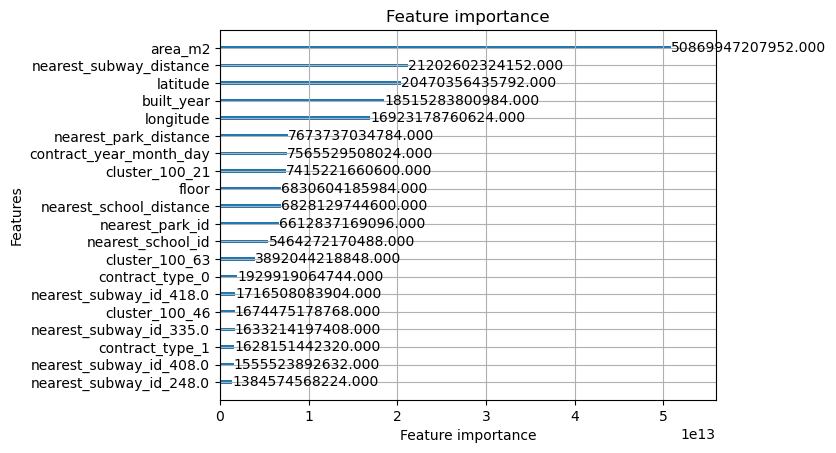

In [113]:
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=20)
plt.title('Feature importance')

(0.0, 1000.0)

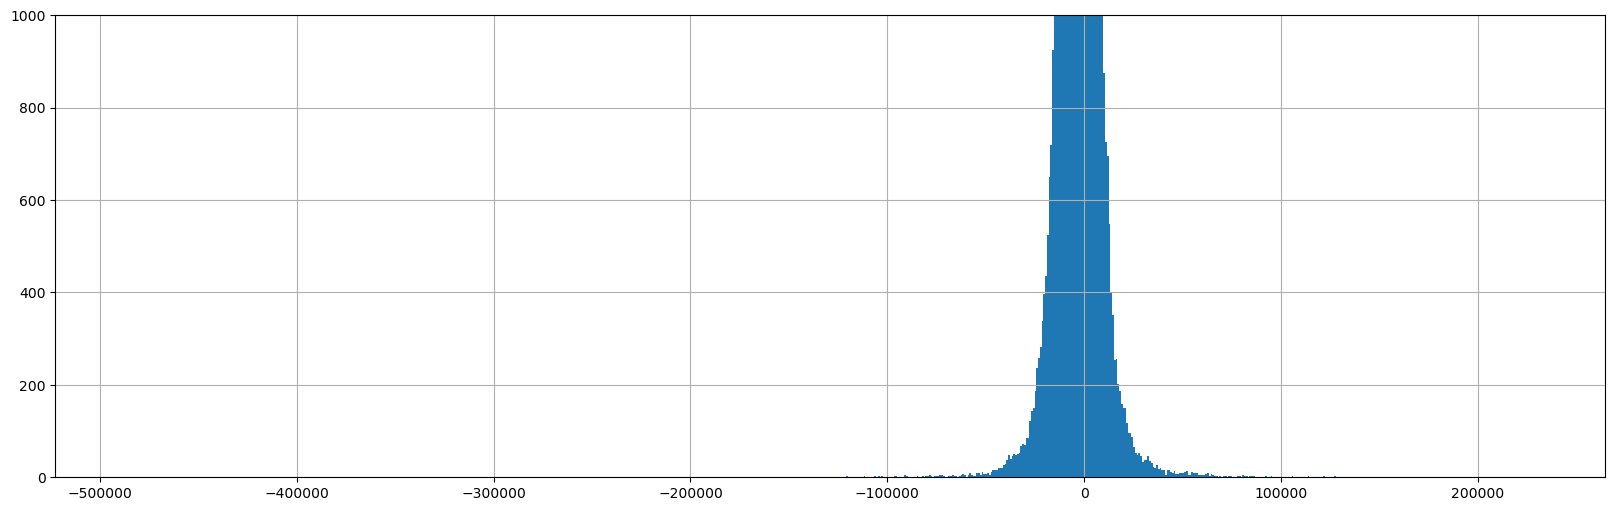

In [80]:
# target_holdout.hist(bins=50, figsize=(20, 6))
pred_df = pd.DataFrame({'pred': lgb_holdout_pred, 'target': y_holdout})
pred_df["diff"] = pred_df["pred"] - pred_df["target"]
pred_df["diff"].hist(bins=800, figsize=(20, 6))
# plt.xlim(-50000, 50000)
plt.ylim(0, 1000)

c:\ProgramData\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


(6.0, 13.977179106750274)

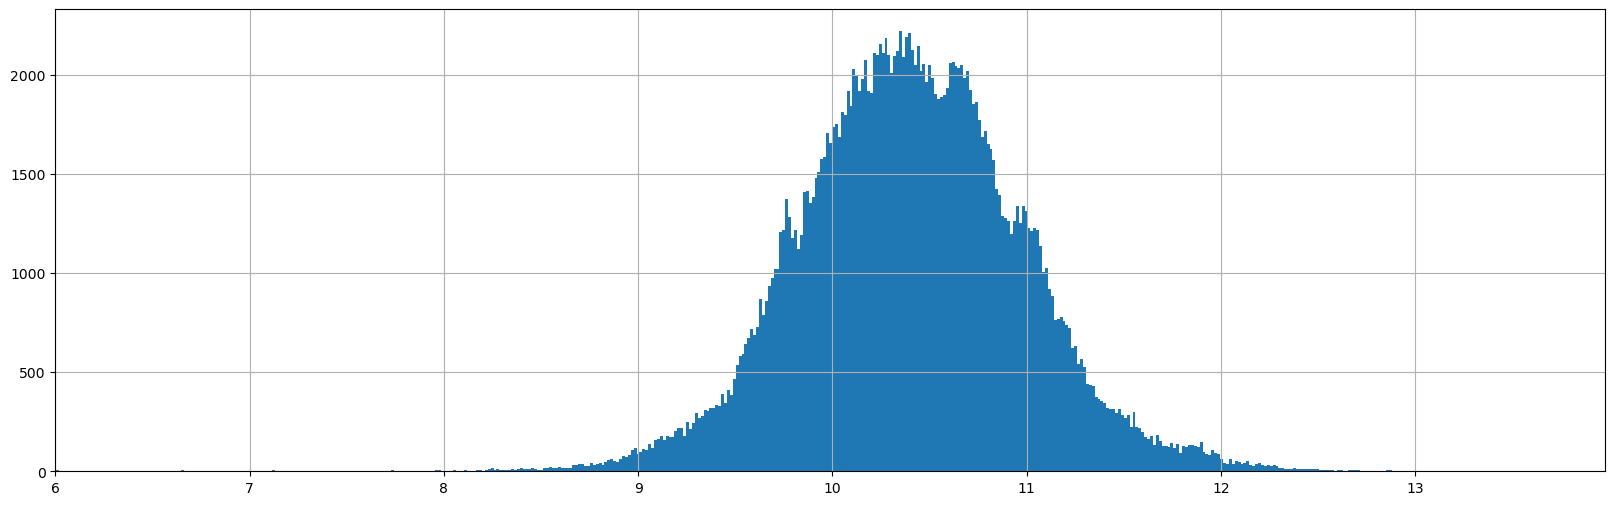

In [70]:
np.log1p(pred_df["pred"]).hist(bins=800, figsize=(20, 6))
plt.xlim(6)

<Axes: >

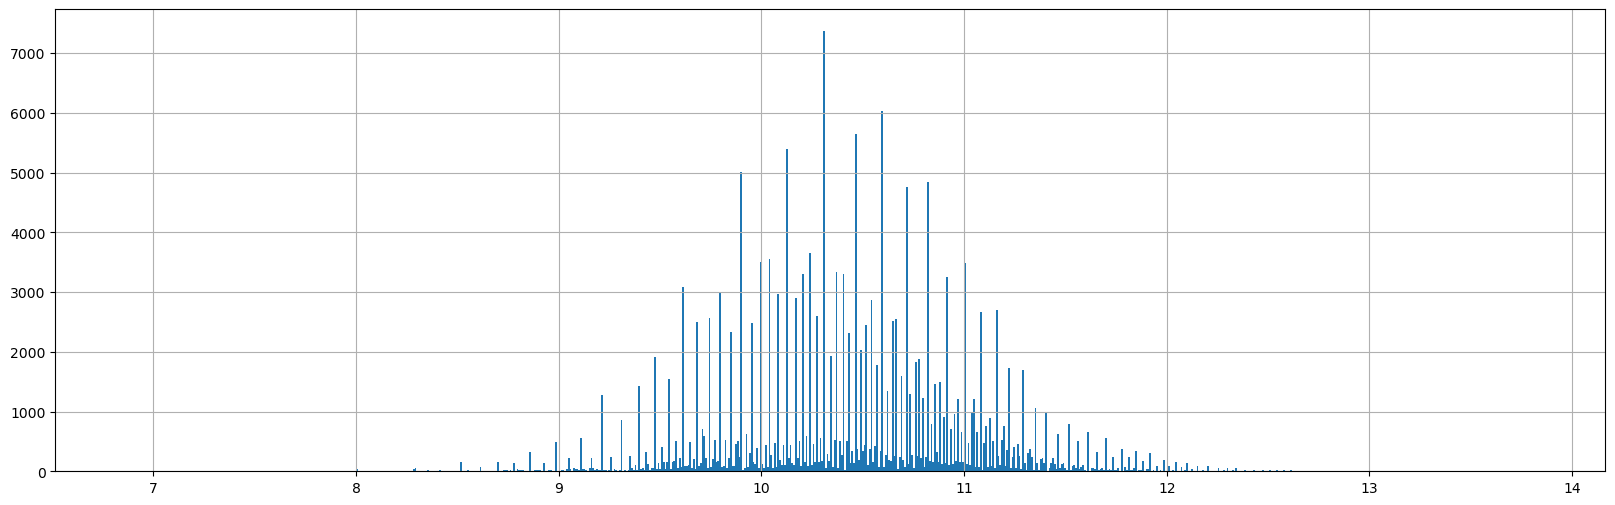

In [68]:
np.log1p(pred_df["target"]).hist(bins=800, figsize=(20, 6))
# plt.xlim(10, 11)

In [69]:
pred_df.describe()

,pred,target,diff
count,198636.000000,198636.000000,198636.000000
mean,39035.473088,40903.631089,-1868.158001
std,26269.380206,28571.795590,7980.016407
min,-12051.577754,955.000000,-486899.636593
25%,22609.586352,23000.000000,-4763.454671
50%,32704.266749,34458.000000,-1310.777952
75%,47659.086564,50000.000000,1365.791011
max,644685.218228,1000000.000000,228879.272841


# Sample Submission 제출하기

In [419]:
# 최종 모델 학습
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)

X_train = train_df.drop(columns=["deposit"])
y_train = train_df["deposit"]

# lightgbm 모델 생성
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)

# batch로 나눠서 학습
batch_size = X_train.shape[0] // batch_num
for i in range(0, X_train.shape[0], batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    
    lgb_model.fit(X_batch, y_batch, init_model=lgb_model if i != 0 else None, verbosity=-1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 198636, number of used features: 108


LGBMRegressor(random_state=42)

In [442]:
# 필요 없는 column 제거
test_df = test_data.drop(columns=["index"])

# contract_year_month, contract_day를 contract_year_month_day로 통합
test_df["contract_year_month_day"] = test_df["contract_year_month"] * 100 + test_df["contract_day"]
test_df.drop(columns=["contract_year_month", "contract_day"], inplace=True)

In [443]:
# cluster & one-hot encoding
test_df['cluster_100'] = kmeans.predict(test_df[['latitude', 'longitude']])
test_df = pd.get_dummies(test_df, columns=["cluster_100"])

In [444]:
lgb_test_pred = lgb_model.predict(test_df)
sample_submission['deposit'] = lgb_test_pred

In [445]:
# 음수값 모두 0으로 보정
# sample_submission[sample_submission['deposit'] < 0] = 0

In [446]:
index = datetime.datetime.now().strftime('%Y%m%d_%H%M')
sample_submission.to_csv(f'../../output/output_{index}_MAE_{lgb_holdout_mae:.2f}.csv', index=False, encoding='utf-8-sig')

# 기타: submission 분포 확인하기

In [424]:
sample_submission.describe()

,index,deposit
count,150172.000000,150172.000000
mean,75080.880297,39381.054336
std,43354.550467,24470.062920
min,0.000000,0.000000
25%,37532.750000,23440.953887
50%,75083.500000,33885.626447
75%,112626.250000,48919.218119
max,150171.000000,679523.389700
